# Stocks
This notebook shows how to treat the stock prices and make some simple analyses of financial time series.

## How to read and handle a csv file
Here we open a csv (comma separated values) file containing the stock prices (in this case, daily close prices). We first get the data from the repository.

In [15]:
from sociophysicsDataHandler import SociophysicsDataHandler

student_config = True

file_target = 'asdz/platform2.2/20200428/ASDZ_Perron2.2_2020042815_trajectorie.parquet' 

if student_config:
    dh = SociophysicsDataHandler()
    dh.fetch_prorail_data_from_path(file_target)
else:
    webdav_basepath='/Crowdflow (Projectfolder)/ProRail_USE_LL_data'
    dh = SociophysicsDataHandler(basepath=webdav_basepath)
    
    dh.fetch_prorail_data_from_path(file_target)
                           # ,basepath=webdav_basepath)

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/asdz/platform2.2/20200428/ASDZ_Perron2.2_2020042815_trajectorie.parquet
data fetched. Accessible as <this-object>.df


In [16]:
import pandas as pd
dh.fetch_econophysics_data_from_path("econophysics/prices/daily_close_prices.csv")
prices = dh.df
prices.index = pd.to_datetime(prices.index) # to be sure that the index is in the pandas DateTime format
print(prices)

trying to fetch: /storage/surfsara/ProRail_USE_LL_data\econophysics/prices/daily_close_prices.csv
data fetched. Accessible as <this-object>.df
              BBBY   NOKIA    AMC       VIAC       FIZZ     GME        AAPL  \
2020-09-01  13.040  3.9890   6.07  27.057624  39.111922    7.65  133.522244   
2020-09-02  12.435  3.9960   7.04  27.653478  39.591016    7.71  130.755872   
2020-09-03  11.830  3.8075   6.60  27.594869  38.609342    7.82  120.287441   
2020-09-04  11.750  3.7645   7.02  28.083274  38.064490    7.65  120.367049   
2020-09-07     NaN  3.6415    NaN        NaN        NaN     NaN         NaN   
...            ...     ...    ...        ...        ...     ...         ...   
2021-07-08  28.450  4.5830  47.94  41.460000  45.400000  191.38  143.240000   
2021-07-09  29.600  4.6545  46.19  42.770000  45.100000  191.23  145.110000   
2021-07-12  30.100  4.6220  42.61  43.440000  44.530000  189.25  144.500000   
2021-07-13  29.350  4.9925  39.35  42.580000  44.380000  180.06  14

## Plot stock daily prices between a certain time range
Define the time range and the stock we want to show, and plot the corresponding close prices.

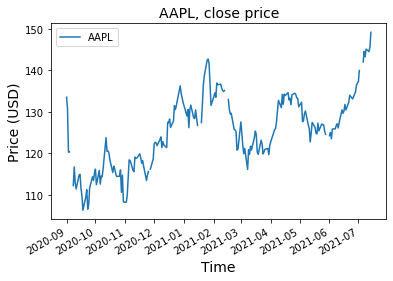

In [35]:
import matplotlib.pyplot as pl
stock = 'AAPL'
start_month = '2012-01'
end_month = '2023-07'
prices_toPlot = prices[[stock]][start_month:end_month]
prices_toPlot.plot()
pl.xlabel('Time', fontsize=14)
pl.ylabel('Price (USD)', fontsize=14)
pl.title(stock + ', close price', fontsize=14)
pl.show()

## Daily returns
Calculate daily returns and their statistics. Daily returns are percentage changes between consecutive prices. For example, if yesterday's price was 150 USD and today's price is 152 USD, then the daily return is (152-150)/150 = 0.013, i.e. 1.3%

In [18]:
rets = prices.pct_change()
print('The mean daily returns are:')
print(rets.mean())
print('The standard deviation of the daily returns are:')
print(rets.std())
# standard deviations of daily returns show the level of fluctuations of the stocks;
# higher standard deviation implies higher stock volatility (see "Calculate stock volatility")

The mean daily returns are:
BBBY     0.006214
NOKIA    0.001435
AMC      0.022607
VIAC     0.002758
FIZZ     0.001370
GME      0.027616
AAPL     0.000703
LGND     0.001295
dtype: float64
The standard deviation of the daily returns are:
BBBY     0.077850
NOKIA    0.028226
AMC      0.238831
VIAC     0.038541
FIZZ     0.043643
GME      0.184224
AAPL     0.020320
LGND     0.035623
dtype: float64


## Filtering and grouping
We can filter the returns dataframe based on some condition (for example, the magnitude of the returns).

In [19]:
return_threshold = 2 # we will select only the days with daily return larger than 2%
stock = 'AAPL'
rets_percent = 100*rets #  transform returns into percent returns to increase readability
rets_percent_large = rets_percent[[stock]][rets_percent > return_threshold] # in the square brackets, we set the condition
rets_percent_small = rets_percent[[stock]][rets_percent < -return_threshold]
rets_percent_large.dropna()

,AAPL
2020-09-09,3.988654
2020-09-14,2.995536
2020-09-21,3.032572
2020-09-25,3.751617
2020-09-28,2.386890
2020-10-05,3.079101
2020-10-12,6.352056
2020-10-29,3.705036
2020-11-04,4.083665
2020-11-05,3.549369


## Calculate stock volatility
From the stock prices and returns we can calculate the volatility, i.e. the average fluctuations of the stock in the last n days. The volatility represents the risk associated to the financial object: the higher the volatility, the riskier the security. In mathematical terms, it is nothing but the weighted variance of the stock returns multiplied by a factor, as shown in the function below.

In [20]:
import numpy as np
import datetime

def volaCalc2(x, w): # x is your pandas dataframe showing the close-close returns and w is a vector of weights
    # in this case, we calculate the volatility on 65 trading days, and we weight the last 5 days twice w.r.t. to the others:
    w = np.append(np.repeat(1, 60),np.repeat(2, 5)) 
    ttt=datetime.datetime.now() # check time
    
    n_col = x.shape[1]
    n_row = x.shape[0]
    n_w = len(w)
    s_w = sum(w)
    tmp_mean = np.tile(np.nan, (n_row, n_col))
    vola = np.tile(np.nan, (n_row, n_col))
    x_array = x.values # transform pandas into array
    
    for j in range(0,n_col): # loop on columns
        tmpcol=x_array[:,j];
        for i in range(0,n_row): # loop on rows
            if i >= n_w:
                tmp_mean[i,j] = sum((w*tmpcol[i+1-n_w:i+1]))/s_w
                vola[i,j] = sum(w*(tmpcol[i+1-n_w:i+1]-tmp_mean[i,j])*(tmpcol[i+1-n_w:i+1]-tmp_mean[i,j]))/(s_w-1) #weighted variance
                
    vola = pd.DataFrame(vola, index = x.index, columns=x.columns)
    print(' total time: '+str((datetime.datetime.now() - ttt).seconds + (datetime.datetime.now() - ttt).microseconds/1E6) + ' s')        
    return(vola)

weights = np.append(np.repeat(1, 60),np.repeat(2, 5))
volatility_daily = np.sqrt(volaCalc2(rets, weights)) # compute the square root of the variance
# this is the daily volatility; usually, though, the volatility is presented in annualized terms 
# assuming there are 252 trading days in a year, we therefore multiply the daily volatility by the square root of 252:
volatility = np.sqrt(252)*volatility_daily
print('The annualized volatility of the last 5 days of the dataset is:')
print(100*volatility.tail())

 total time: 0.027903 s
The annualized volatility of the last 5 days of the dataset is:
                  BBBY      NOKIA         AMC       VIAC       FIZZ  \
2021-07-08  145.644163  30.612944  230.406843  36.940056  38.971586   
2021-07-09  145.772771  30.704828  230.337403  37.758668  38.452798   
2021-07-12  145.768299  30.782069  231.034456  36.691307  37.677521   
2021-07-13  145.404070  36.763003  232.386338  36.526280  37.557967   
2021-07-14  143.790042  36.733206  235.894111  36.783403  37.338670   

                   GME       AAPL       LGND  
2021-07-08  116.610687  20.670376  40.385423  
2021-07-09  115.739519  20.315857  40.391572  
2021-07-12  113.736113  20.174233  39.499638  
2021-07-13  114.582513  19.623029  39.877675  
2021-07-14  110.726023  19.930626  40.116511  


## Time zones
One of the crucial aspects, when dealing with financial time series, is paying attention to the time zones in which the data are expressed. This is important if we want to correctly match the Reddit database (where times are expressed in UTC a.k.a. GMT) with the stock database (expressed in New York time). Here we show how to transform the latter into UTC time. This issue is only present when dealing with intraday prices (in this case, at hourly resolution).

In [21]:
dh.fetch_econophysics_data_from_path("econophysics/prices/hourly_prices.csv")
prices_hour = dh.df
prices_hour.index = pd.to_datetime(prices_hour.index) # to be sure that the index is in the pandas DateTime format
print(prices_hour)

trying to fetch: /storage/surfsara/ProRail_USE_LL_data\econophysics/prices/hourly_prices.csv
data fetched. Accessible as <this-object>.df
                           AAPL    AMC   BBBY       FIZZ     GME    LGND  \
2020-08-31 20:00:00  128.705970    NaN    NaN        NaN     NaN     NaN   
2020-09-01 04:00:00         NaN    NaN    NaN        NaN     NaN     NaN   
2020-09-01 05:00:00  131.482293    NaN  12.18        NaN     NaN     NaN   
2020-09-01 06:00:00  131.750970    NaN    NaN        NaN     NaN     NaN   
2020-09-01 07:00:00  131.741019    NaN    NaN  38.163127     NaN     NaN   
...                         ...    ...    ...        ...     ...     ...   
2021-07-14 15:00:00  149.320000  34.86  28.17  44.250000  171.46  119.51   
2021-07-14 16:00:00  149.210000  33.42  27.87  43.700000  167.61  118.22   
2021-07-14 17:00:00  149.290000  33.43  27.89  43.700000  167.62  118.16   
2021-07-14 18:00:00  149.430000    NaN  27.95  43.560000     NaN     NaN   
2021-07-14 19:00:00  149.4

In [22]:
# the times you see in the index of prices_hour are expressed in New York time (American Eastern Time) 
# American Eastern Time is defined as UTC-5 in autumn and winter, and UTC-4 in spring and summer (daylight saving)
import datetime as dt
from dateutil import tz # library to treat timezones
NYC = tz.gettz('America/New_York') # define the New York timezone

# we begin with a single time as an example; let's take the 13th entry in the prices dataframe:
i = 13
dat = str(prices_hour.index[i].date())
print('The considered date is:', dat)
print('In particular, we are considering the index:', prices_hour.index[i], 'in New York time')

The considered date is: 2020-09-01
In particular, we are considering the index: 2020-09-01 16:00:00 in New York time


In [23]:
# let's compute the offset between New York time and UTC (the time we want to use) on that date:
dt1 = dt.datetime(int(dat[0:4]), int(dat[5:7]),int(dat[8:10]), tzinfo=NYC)
UTC_lag = dt1.utcoffset() / dt.timedelta(hours=1)
print('On', dat, 'the offset is', UTC_lag, 'hours')

On 2020-09-01 the offset is -4.0 hours


In [24]:
# now we can actually transform the time index into UTC:
new_index = prices_hour.index[i] - pd.Timedelta(hours=UTC_lag)
print('The 13th index in New York time is:', prices_hour.index[i])
print('The 13th index in UTC time is:', new_index)

The 13th index in New York time is: 2020-09-01 16:00:00
The 13th index in UTC time is: 2020-09-01 20:00:00


In [25]:
# if we do the same for a winter day, then we see that the offset is in that case 5 hours
i = 2000
dat = str(prices_hour.index[i].date())
dt1 = dt.datetime(int(dat[0:4]), int(dat[5:7]),int(dat[8:10]), tzinfo=NYC)
UTC_lag = dt1.utcoffset() / dt.timedelta(hours=1)
print('On', dat, 'the offset is', UTC_lag, 'hours')

On 2021-02-18 the offset is -5.0 hours


In [26]:
# we can therefore transform the whole dataframe based on this rule:
prices_hour

,AAPL,AMC,BBBY,FIZZ,GME,LGND,NOKIA,VIAC
2020-08-31 20:00:00,128.705970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.1155,NaN
2020-09-01 05:00:00,131.482293,NaN,12.18,NaN,NaN,NaN,4.0575,NaN
2020-09-01 06:00:00,131.750970,NaN,NaN,NaN,NaN,NaN,4.0535,NaN
2020-09-01 07:00:00,131.741019,NaN,NaN,38.163127,NaN,NaN,4.0800,27.204146
...,...,...,...,...,...,...,...,...
2021-07-14 15:00:00,149.320000,34.86,28.17,44.250000,171.46,119.51,NaN,42.070000
2021-07-14 16:00:00,149.210000,33.42,27.87,43.700000,167.61,118.22,NaN,41.920000
2021-07-14 17:00:00,149.290000,33.43,27.89,43.700000,167.62,118.16,NaN,41.920000
2021-07-14 18:00:00,149.430000,NaN,27.95,43.560000,NaN,NaN,NaN,41.800000


In [27]:
new_index_list = []
for i in range(len(prices_hour)):
    # for each index, make the previous index transformation:
    old_index = prices_hour.index[i]
    dat = str(old_index.date())
    dt1 = dt.datetime(int(dat[0:4]), int(dat[5:7]),int(dat[8:10]), tzinfo=NYC)
    UTC_lag = dt1.utcoffset() / dt.timedelta(hours=1)
    new_index = prices_hour.index[i] - pd.Timedelta(hours=UTC_lag)
    # attach the UTC index to the new index list:
    new_index_list.append(new_index)
    
# set the new UTC index to the prices_hour dataframe:
prices_hour.index = new_index_list

In [28]:
prices_hour

,AAPL,AMC,BBBY,FIZZ,GME,LGND,NOKIA,VIAC
2020-09-01 00:00:00,128.705970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.1155,NaN
2020-09-01 09:00:00,131.482293,NaN,12.18,NaN,NaN,NaN,4.0575,NaN
2020-09-01 10:00:00,131.750970,NaN,NaN,NaN,NaN,NaN,4.0535,NaN
2020-09-01 11:00:00,131.741019,NaN,NaN,38.163127,NaN,NaN,4.0800,27.204146
...,...,...,...,...,...,...,...,...
2021-07-14 19:00:00,149.320000,34.86,28.17,44.250000,171.46,119.51,NaN,42.070000
2021-07-14 20:00:00,149.210000,33.42,27.87,43.700000,167.61,118.22,NaN,41.920000
2021-07-14 21:00:00,149.290000,33.43,27.89,43.700000,167.62,118.16,NaN,41.920000
2021-07-14 22:00:00,149.430000,NaN,27.95,43.560000,NaN,NaN,NaN,41.800000
